By Luke Leckie. Code for publication entitled "The content and structure of dreams are coupled to affect "
This script:
1. Extracts topic networks
2. Assign affect to topics and reports
3. Several plotting and analysis steps

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import cython
import pickle
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import normalize
import numpy as np
import networkx as nx
from scipy.stats import linregress
from scipy import stats
from collections import defaultdict
%matplotlib inline
from matplotlib.gridspec import GridSpec

###have in the same folder as jupyter script v
import semantic_network_functions as sn


Load in our corpus, with atoms assigned to narratives. By now a Discourse Atom Topic Model should have been trained and atoms should have been assigned to narratives: https://github.com/arsena-k/discourse_atoms

In [ ]:
n_topics='130'
direc=''#Dictionaries here
model_dir=''
direc_dict=''
w2vmodel=  Word2Vec.load(model_dir+"dream_model_100_10_5")#Your embedding
infile = open(direc_dict+f'{n_topics}comp5nonzeros_dictionary','rb')#Your DATM dictionary
dictionary=pickle.load(infile)
infile.close()
corpus = pd.read_csv(direc+f"dream_corpus_atoms_{n_topics}_5.csv")#Your corpus
dropped_rows = corpus[corpus['atom_seq'].isna()]
corpus = corpus.dropna(subset=['atom_seq']).reset_index(drop=True)
print(len(corpus))

In [7]:
n_topics='130'
n='18'
direc='/home/ll16598/Documents/altered_states/2024/'
model_dir='/home/ll16598/Documents/altered_states/2024/models/'
direc_dict='/home/ll16598/Documents/altered_states/2024/105and155paramaterisation/'
w2vmodel=  Word2Vec.load(model_dir+"dream_model_100_10_5") #name of YOUR model here, or file path to your model.
#infile = open(direc_dict+'220comp5nonzeros_dictionary','rb')
infile = open(direc_dict+f'{n_topics}comp5nonzeros_dictionary{n}','rb')

dictionary=pickle.load(infile)
infile.close()
corpus = pd.read_csv(direc+f"dream_corpus_atoms_march_{n_topics}_5_{n}.csv") 
extra_data= pd.read_csv(direc+"dreams_fppQ_1.csv") 
new_columns = extra_data[extra_data.columns.difference(corpus.columns)]
corpus = pd.concat([corpus, new_columns], axis=1)
corpus['bert_Valence']=corpus['Valence']
extra_data=None
print(len(corpus))
dropped_rows = corpus[corpus['atom_seq'].isna()]
corpus = corpus.dropna(subset=['atom_seq']).reset_index(drop=True)
print(len(corpus))


21372
19954


In [173]:
test_mode=True
if test_mode:
    corpus=corpus.iloc[0:200]

This extracts semantic structure graphs for each atom sequence. These are what we perform our analysis on.

In [174]:
corpus['graphs'] = corpus['atom_seq'].apply(lambda cell: sn.structureG(cell, dictionary))
#option without cosine edge weights, much less memory heavy
#corpus['graphs'] = corpus['atom_seq'].apply(lambda cell: sn.structureG_simple(cell, dictionary))

Now we calculate our network properties.

In [175]:
measures_df = corpus['graphs'].apply(sn.calculate_measures)
corpus = pd.concat([corpus, measures_df], axis=1)

In [176]:
measures_df = corpus['graphs'].apply(sn.calculate_measures)
corpus = pd.concat([corpus, measures_df], axis=1)

This just gets the first and last atom in a sequence, and then calculates path length between first and last (unweighted and inverse cosine weighted)

In [177]:
corpus['first']=corpus['atom_seq'].apply(sn.get_first)
corpus['last']=corpus['atom_seq'].apply(sn.get_last)
corpus[['s_to_e_path', 's_to_e_path_cosine']] = corpus.apply(sn.calculate_paths, axis=1)

Last, we get the mean and standard deviation of the cosine similarity between neighboring topics in our networks

In [178]:
corpus=sn.get_weights(corpus)
corpus['Mean coherence']=corpus['weights'].apply(np.mean)
corpus['Std. coherence']=corpus['weights'].apply(np.std)

/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Now we assign the affect to our dreams. First we need to make dimensions of valence and arousal from seed words.

In [12]:
lo_list=['lazy', 'bored', 'tired','peaceful','relaxed','calm']#Low arousal
hi_list=['energetic', 'delighted', 'excited','tense', 'angry', 'frustrated']#High arousal
pos_list=['good', 'happy', 'relaxed','confident','safe','love']#Positive valence
neg_list=['bad', 'sad', 'angry','anxious','scared','disgust']#Negative valence
positive_vec=sn.creat_vec(pos_list, w2vmodel)
negative_vec=sn.creat_vec(neg_list, w2vmodel)
high_arousal_vec=sn.creat_vec(hi_list, w2vmodel)
low_arousal_vec=sn.creat_vec(lo_list, w2vmodel)
pos_neg_vec = normalize(positive_vec.reshape(1, -1)) - normalize(negative_vec.reshape(1, -1))
hi_low_vec = normalize(high_arousal_vec.reshape(1, -1)) - normalize(low_arousal_vec.reshape(1, -1))

Now we make separate dictionaries to store the valence and arousal of each atom.

In [13]:
print_valence=True
print_arousal=False
cossim_pos_neg = {}
for i in range(0, len(dictionary)):
    cos_sim = cosine_similarity(pos_neg_vec.reshape(1, -1), dictionary[i].reshape(1, -1))[0]
    if print_valence:
        print("Discourse_Atom " + str(i)) #Print discourse atom and valence
        print([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary[i], topn=25)])
        print("Valence=", cos_sim)
    cossim_pos_neg[str(i)]=cos_sim
    
cossim_high_low = {}
for i in range(0, len(dictionary)):
    cos_sim = cosine_similarity(hi_low_vec.reshape(1, -1), dictionary[i].reshape(1, -1))[0]
    if print_arousal:
        print("Discourse_Atom " + str(i)) #Print discourse atom and arousal
        print([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary[i], topn=25)])
        print("Arousal=",cos_sim)
    cossim_high_low[str(i)]=cos_sim

Discourse_Atom 0
['said_oh', 'replied', 'implying', 'said', 'knows', 'says', 'says_oh', 'kept_saying', 'replies', 'saying', 'said_yeah', 'tells_me', 'thinks', 'said_yes', 'meaning', 'mentioned', 'knowing', 'assures_me', 'says_yes', 'admitted', 'answered', 'answers', 'indicating', 'means', 'explains']
Valence= [0.00924494]
Discourse_Atom 1
['week', 'month', 'few_days', 'hours', 'weekend', 'weeks', 'year', 'half_hour', 'afternoon', 'an_hour', 'hour', 'meal', 'exam', 'two_weeks', 'evening', 'long_time', 'months', 'exams', 'two_days', 'day', 'few_weeks', 'minutes', 'christmas', 'few_months', 'few_hours']
Valence= [0.09636436]
Discourse_Atom 2
['asked', 'wondered', 'ask', 'kept_asking', 'asking', 'wasnt_sure', 'dont_know', 'wonder', 'wonders', 'asks', 'would_happen', 'didnt_understand', 'didnt_know', 'couldnt_understand', 'explained', 'explaining', 'not_knowing', 'dont_understand', 'cant_understand', 'not_sure', 'cant_recall', 'cant_remember', 'no_matter', 'meant', 'knows']
Valence= [0.0769

Now we can use these dictionaries to assign report-level scores of valence and arousal

In [21]:
corpus['median_Valence'] = corpus['atom_seq'].apply(lambda x: sn.calculate_median_affect(x, cossim_pos_neg))
corpus['median_Arousal'] = corpus['atom_seq'].apply(lambda x: sn.calculate_median_affect(x, cossim_high_low))

Now we can plot a graph, with nodes colored by valence and sized by in-degree

Dream:
 '143', ' '1/30/87', ' "I'm in a small place, an apartment or motel room, where I'm staying with my mom and [somebody else - a brother or 2?]. A very abbreviated place, small rooms and flimsy fixtures, like the Motel 6 was. It has a kitchen. There's a telephone on the wall next to the kitchen. It hangs sideways and has a round earpiece and the mouthpiece is sort of the end of the metal rod that you hold. You can't prop it on your shoulder. Mom's not here. Somebody else comes in, a boy (we're all young here) with some clay figures to show us. He takes them out of plastic bags. He hands me a sort of rabbit-lady, and I quite like it, but it's still a bit soft and some of it comes apart in my hand. I'm afraid if I grasp it with my other hand I'll smush it. Or if I put it down. I feel terribly responsible for it. Nobody else is paying attention yet, he's showing others to my brother and I'm sitting there, very uncomfortable, and I would really like to get up and go do something else.

/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


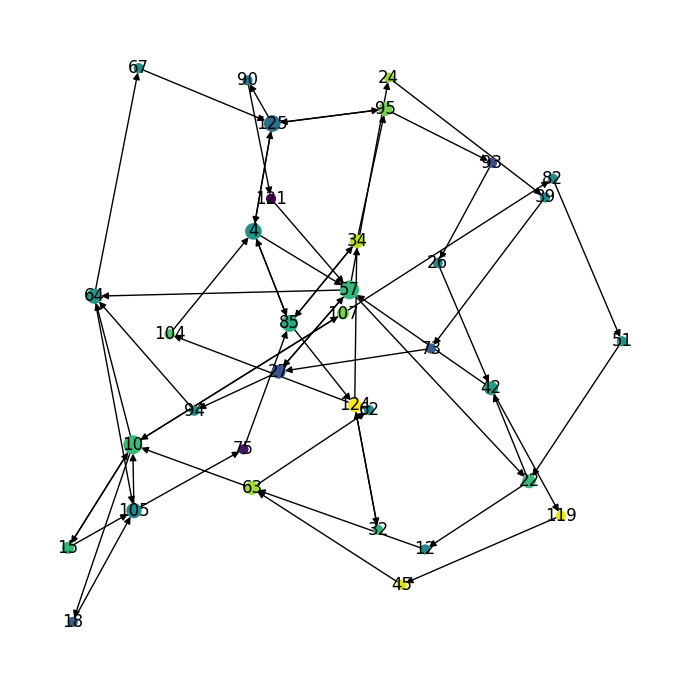

In [182]:
print_similar_words=False#Make true if you want to see the most representative words for each topic
figwidth = 7
figheight = 7
k = 85#8587
G = corpus['graphs'][k]
print('Dream:')
print(corpus['dreams'][k])
print('Atom sequence:')
print(corpus['atom_seq'][k])
if print_similar_words:
    print('Most similar words to each topic:')
    sn.print_topics(corpus['atom_seq'].iloc[k].split(), topn=5)
print('Valence:')
print(corpus['median_Valence'][k])
print('Arousal:')
print(corpus['median_Arousal'][k])
cos_sim_values = [cossim_pos_neg[str(topic)] for topic in G.nodes()]
norm = plt.Normalize(vmin=min(cos_sim_values), vmax=max(cos_sim_values))
colors = plt.cm.viridis(norm(cos_sim_values))
cmap = plt.cm.viridis
np.random.seed(42) 
# Calculate node sizes based on in-degree
in_degree = dict(G.degree())
sizes = [in_degree[node]*20 for node in G.nodes()]
fig = plt.figure(figsize=(figwidth, figheight))
gs = gridspec.GridSpec(1, 1, width_ratios=[1])
ax0 = plt.subplot(gs[0])
pos = nx.spring_layout(G)
nx.draw(G, ax=ax0, pos=pos, with_labels=True, node_color=colors, cmap=cmap, node_size=sizes)
plt.tight_layout()
plt.show()


In [23]:
#Clean the corpus, so no pathologies
corpus_cleaned=corpus[~corpus['description'].isin(['Blind dreamers (F)',\
                                                          'Blind dreamers (M)', \
                                                          'Edna: a blind woman',\
                                                         'Vietnam Vet: 1970-2008 war dreams',\
                                                         'Norman: a child molester'])]

Now we have our topic networks and their properties. Save data for PLS in Pt2. 

In [ ]:
corpus_cleaned.to_csv(f'')
print('saved!')

Now we can plot the valence and arousal of each topic and also each narrative. First we calculate the prevalence of each topic in our corpus, and then key this to it's valence and arousal.

In [185]:
topic_counter={}
for i in corpus_cleaned['atom_seq']:
    topics=set(i.split())#use set so that it is just the occurence of a topic once in a narrative
    for t in topics:
        if t not in topic_counter:
            topic_counter[t]=1
        else:
            topic_counter[t]+=1
for key in topic_counter.keys():
    topic_counter[key]=topic_counter[key]/len(corpus_cleaned['atom_seq'])

emotion_df=pd.DataFrame({
    'topic':cossim_high_low.keys(),
    'arousal':cossim_high_low.values(),
    'valence':cossim_pos_neg.values()
})
prev=[]
for topic in emotion_df['topic']:
    prev.append(topic_counter[topic])
emotion_df['prevalence']=prev
emotion_df['arousal'] = emotion_df['arousal'].apply(lambda x: x[0] if x else None)
emotion_df['valence'] = emotion_df['valence'].apply(lambda x: x[0] if x else None)


In [39]:
#Plotting parameters
linewidth=0.8
tick_length=1
linewidth=1
pointwidth = 0.7
linewidth2 = 1
lincolor='black'
labsize=7
titlesize=10
barwidth=0.57
barcol='#6baed6'
textcol='black'
pointsize=5
pointalpha=0.4
pointsize2=12
dir_fig_save='/home/ll16598/Documents/altered_states/2024/plots/'
savefig=False#savefigure
text=False#label points

Now we can plot each topics valence and arousal and make a kernel density map of the reports over these dimensions. 

/tmp/ipykernel_13412/749712481.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(corpus_cleaned["median_Valence"], intercept_corpus + slope_corpus * corpus_cleaned["median_Valence"], 'k-',color='black') # Black fit line


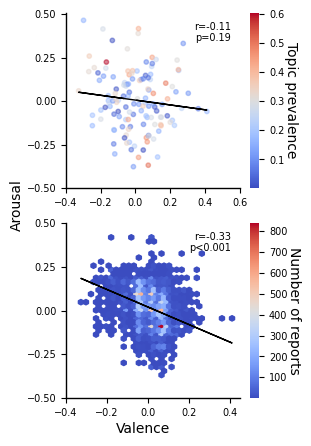

In [189]:

fig = plt.figure(figsize=(2.8, 5))
gs = GridSpec(2, 1, width_ratios=[1]) 
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
slope_emotion, intercept_emotion, r_value_emotion, p_value_emotion, std_err_emotion = linregress(emotion_df["valence"], emotion_df["arousal"])
slope_corpus, intercept_corpus, r_value_corpus, p_value_corpus, std_err_corpus = linregress(corpus_cleaned["median_Valence"], corpus_cleaned["median_Arousal"])
scatter1=ax0.scatter(emotion_df["valence"], emotion_df["arousal"], c=emotion_df["prevalence"], # Use prevalence for color mapping
                      cmap='coolwarm', 
                      alpha=1, s=0)
scatter=ax0.scatter(emotion_df["valence"], emotion_df["arousal"], c=emotion_df["prevalence"], # Use prevalence for color mapping
                      cmap='coolwarm', 
                      alpha=0.5, s=10)
if text:
    for i, point in emotion_df.iterrows():
        ax0.text(point['valence'], point['arousal'], point['topic'],
                 fontsize=4, ha='center', va='center')

ax0.plot(emotion_df["valence"], intercept_emotion + slope_emotion * emotion_df["valence"], 'k-') # Black fit line
ax0.text(0.95, 0.95, f'r={r_value_emotion:.2f}\np={p_value_emotion:.2f}', transform=ax0.transAxes, ha='right', va='top', color='black', fontsize=labsize)
hexb=ax1.hexbin(corpus_cleaned["median_Valence"], corpus_cleaned["median_Arousal"], gridsize=30, cmap='coolwarm', mincnt=1)
ax1.plot(corpus_cleaned["median_Valence"], intercept_corpus + slope_corpus * corpus_cleaned["median_Valence"], 'k-',color='black') # Black fit line
ax1.text(0.95, 0.95, f'r={r_value_corpus:.2f}\np<0.001', transform=ax1.transAxes, ha='right', va='top', color='black', fontsize=labsize)

cbar = plt.colorbar(scatter1, ax=ax0)
cbar.set_label('Topic prevalence', size=titlesize, rotation=270, labelpad=10)
cbar.ax.tick_params(labelsize=labsize)
cbar.outline.set_visible(False)  
cbar = plt.colorbar(hexb, ax=ax1)
cbar.set_label('Number of reports', size=titlesize, rotation=270, labelpad=10)
cbar.ax.tick_params(labelsize=labsize)
cbar.outline.set_visible(False)  

axs=[ax0,ax1]

for i,ax in enumerate(axs):
    ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=labsize)
    y_ticks = np.arange(-0.5, 0.55, 0.25)  # Adjust x_min and x_max as needed
    if i ==0:
        x_ticks = np.arange(-0.4, 0.7, 0.2)  # Adjust y_min and y_max as needed
    else:
        x_ticks = np.arange(-0.4, 0.5, 0.2)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['left'].set_color(lincolor)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['bottom'].set_color(lincolor)
    for line in ax.lines:
        line.set_linewidth(linewidth2)

fig.text(0.4, 0.04, 'Valence', ha='center', rotation=0, fontsize=titlesize, fontweight='normal')
fig.text(-0.05, 0.45, 'Arousal', ha='center', rotation=90, fontsize=titlesize, fontweight='normal')
if savefig:
    if text:
        plt.savefig(dir_fig_save+f'topic_map_text.png', dpi=800,  bbox_inches='tight')
    else:
        plt.savefig(dir_fig_save+f'topic_map.png', dpi=800,  bbox_inches='tight')


See how the affect of a topic corresponds to the average affect of its neighbours in topic networks.

In [190]:
param='median_Valence'
def neighbor_valence(G,valence_dict):
    topics = G.nodes()
    valence1=[]
    valences=[]
    for node in topics:
        valence1.append(valence_dict.get(str(node), 0))
        valences.append(np.mean([valence_dict.get(str(topic), 0) for topic in G.neighbors(node)]))  # Default to 0 if topic not in valence_dict
    return valence1, valences, [str(node) for node in topics] # Return a float

df = corpus_cleaned
df['Sentiment_Quantile'] = pd.qcut(df[param], 4, labels=[0, 1, 2, 3])
df_pos = df[df['Sentiment_Quantile'].isin([3])]
df_neg = df[df['Sentiment_Quantile'].isin([0])]

valence_og=[]
valence_neighbours=[]
arousal_og=[]
arousal_neighbours=[]
topic_list=[]
valence_og2=[]
valence_neighbours2=[]
topic_list2=[]
dreamer_list=[]
gender_list=[]
valence_list=[]
for idx, row in df.iterrows():
    G = row['graphs'] 
    valence1, valences, topics=neighbor_valence(G, cossim_pos_neg)
    arousal1, arousals, topics=neighbor_valence(G, cossim_high_low)
    valence_og.extend(valence1)
    valence_neighbours.extend(valences)
    arousal_og.extend(arousal1)
    arousal_neighbours.extend(arousals)
    topic_list.extend(topics)
    
data = pd.DataFrame({
    'Topic': topic_list,
    'Valence_OG': valence_og,
    'Valence_Neighbours': valence_neighbours
})

# Group by topic to aggregate neighbor valences
grouped_data = data.groupby('Topic').agg({
    'Valence_OG': 'first',  # Assuming the original valence (Valence_OG) is the same for each topic occurrence
    'Valence_Neighbours': 'mean'  # Get the mean of the average neighbor valences
}).reset_index()

valence_og=[]
valence_neighbours=[]
arousal_og=[]
arousal_neighbours=[]
topic_list=[]
valence_og2=[]
valence_neighbours2=[]
topic_list2=[]
dreamer_list=[]
gender_list=[]
valence_list=[]
for idx, row in df_pos.iterrows():
    G = row['graphs']  # Extract the graph
    valence1, valences, topics=neighbor_valence(G, cossim_pos_neg)
    arousal1, arousals, topics=neighbor_valence(G, cossim_high_low)
    valence_og.extend(valence1)
    valence_neighbours.extend(valences)
    arousal_og.extend(arousal1)
    arousal_neighbours.extend(arousals)
    topic_list.extend(topics)
    
data = pd.DataFrame({
    'Topic': topic_list,
    'Valence_OG': valence_og,
    'Valence_Neighbours': valence_neighbours
})

# Group by topic to aggregate neighbor valences
grouped_data_pos = data.groupby('Topic').agg({
    'Valence_OG': 'first',  # Assuming the original valence (Valence_OG) is the same for each topic occurrence
    'Valence_Neighbours': 'mean'  # Get the mean of the average neighbor valences
}).reset_index()

valence_og=[]
valence_neighbours=[]
arousal_og=[]
arousal_neighbours=[]
topic_list=[]
valence_og2=[]
valence_neighbours2=[]
topic_list2=[]
dreamer_list=[]
gender_list=[]
valence_list=[]
for idx, row in df_neg.iterrows():
    G = row['graphs']  # Extract the graph
    valence1, valences, topics=neighbor_valence(G, cossim_pos_neg)
    arousal1, arousals, topics=neighbor_valence(G, cossim_high_low)
    valence_og.extend(valence1)
    valence_neighbours.extend(valences)
    arousal_og.extend(arousal1)
    arousal_neighbours.extend(arousals)
    topic_list.extend(topics)
    
data = pd.DataFrame({
    'Topic': topic_list,
    'Valence_OG': valence_og,
    'Valence_Neighbours': valence_neighbours
})

grouped_data_neg = data.groupby('Topic').agg({
    'Valence_OG': 'first', 
    'Valence_Neighbours': 'mean'
}).reset_index()

data2 = pd.DataFrame({
    'Topic': topic_list,
    'Arousal_OG': arousal_og,
    'Arousal_Neighbours': arousal_neighbours
})
grouped_data2 = data2.groupby('Topic').agg({
    'Arousal_OG': 'first',
    'Arousal_Neighbours': 'mean' 
}).reset_index()

/tmp/ipykernel_13412/12275978.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_Quantile'] = pd.qcut(df[param], 4, labels=[0, 1, 2, 3])
/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ll16598/miniconda3/envs

We need to make dfs to compare network coherence between affective quartiles.

In [191]:
#Divide data into quartiles
df=corpus_cleaned
df['Sentiment_Quantile'] = pd.qcut(df['median_Valence'], 4, labels=[0, 1, 2, 3])
df['Arousal_Quantile'] = pd.qcut(df['median_Arousal'], 4, labels=[0, 1, 2, 3])

df_pos = df[df['Sentiment_Quantile'].isin([3])]
df_neg = df[df['Sentiment_Quantile'].isin([0])]
df_high = df[df['Arousal_Quantile'].isin([3])]
df_low = df[df['Arousal_Quantile'].isin([0])]
def calculate_stats(df):
    means = []
    stds = []
    for weights in df['weights']:
        mean = np.mean(weights)
        std = np.std(weights)
        means.append(mean)
        stds.append(std)
    return means, stds

# Calculate mean and std of coherence for each DataFrame
mean_pos, std_pos = calculate_stats(df_pos)
mean_neg, std_neg = calculate_stats(df_neg)
mean_high, std_high = calculate_stats(df_high)
mean_low, std_low = calculate_stats(df_low)

# Create a DataFrame for plotting
plot_data_sentiment = pd.DataFrame({
    'mean': mean_pos + mean_neg,
    'std': std_pos + std_neg,
    'Quantile': ['Positive'] * len(mean_pos) + ['Negative'] * len(mean_neg)
})

plot_data_arousal = pd.DataFrame({
    'mean': mean_high + mean_low,
    'std': std_high + std_low,
    'Quantile': ['High'] * len(mean_high) + ['Low'] * len(mean_low)
})

/tmp/ipykernel_13412/4053521429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_Quantile'] = pd.qcut(df['median_Valence'], 4, labels=[0, 1, 2, 3])
/tmp/ipykernel_13412/4053521429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Arousal_Quantile'] = pd.qcut(df['median_Arousal'], 4, labels=[0, 1, 2, 3])
/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=d

In [192]:
edge_dat_sentiment=pd.concat([df_pos, df_neg])
edge_dat_arousal=pd.concat([df_high, df_low])
edge_dat_sentiment.to_csv('/home/ll16598/Documents/altered_states/2024/val_edge_data.csv')
edge_dat_arousal.to_csv('/home/ll16598/Documents/altered_states/2024/aro_edge_data.csv')

Now we run an R script to perform LMMs to compare mean and std. of coherence between quartiles.

In [31]:
%load_ext rpy2.ipython

In [196]:
%%R 
rm(list=ls())
library(lme4)
library(car)

stats_R_affect <- function() {
    dat <- read.csv('/home/ll16598/Documents/altered_states/2024/val_edge_data.csv', header=T, stringsAsFactors = F)
    model_formula <- as.formula(paste('Mean.coherence', "~ Sentiment_Quantile+(1|dreamer)", sep = ""))
    model <- lmer(model_formula, data = dat)
    print('MEAN RESULTS:')
    hist(resid(model))
    print(car::Anova(model, type=2))
    print(summary(model))
    model_formula <- as.formula(paste('Std..coherence', "~ Sentiment_Quantile+(1|dreamer)", sep = ""))
    model <- lmer(model_formula, data = dat)
    print('STD RESULTS:')
    hist(resid(model))
    print(car::Anova(model, type=2))
    print(summary(model))
    dat <- read.csv('/home/ll16598/Documents/altered_states/2024/aro_edge_data.csv', header=T, stringsAsFactors = F)
    model_formula <- as.formula(paste('Mean.coherence', "~ Sentiment_Quantile+(1|dreamer)", sep = ""))
    model <- lmer(model_formula, data = dat)
    print('MEAN RESULTS AROUSAL:')
    hist(resid(model))
    print(car::Anova(model, type=2))
    print(summary(model))
    model_formula <- as.formula(paste('Std..coherence', "~ Sentiment_Quantile+(1|dreamer)", sep = ""))
    model <- lmer(model_formula, data = dat)
    print('STD RESULTS AROUSAL:')
    hist(resid(model))
    print(car::Anova(model, type=2))
    print(summary(model))
}

[1] "MEAN RESULTS:"
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: Mean.coherence
                   Chisq Df Pr(>Chisq)    
Sentiment_Quantile 76.94  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: Mean.coherence ~ Sentiment_Quantile + (1 | dreamer)
   Data: dat

REML criterion at convergence: -24734.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5668 -0.5184 -0.0553  0.4662  8.5343 

Random effects:
 Groups   Name        Variance  Std.Dev.
 dreamer  (Intercept) 0.0001808 0.01344 
 Residual             0.0041506 0.06442 
Number of obs: 9389, groups:  dreamer, 62

Fixed effects:
                    Estimate Std. Error t value
(Intercept)        0.2457921  0.0021198 115.951
Sentiment_Quantile 0.0049856  0.0005684   8.772

Correlation of Fixed Effects:
            (Intr)
Sntmnt_Qntl -0.276
[1] "STD RESULTS:"
Analysis of Deviance Table (Type II Wald chisquare te

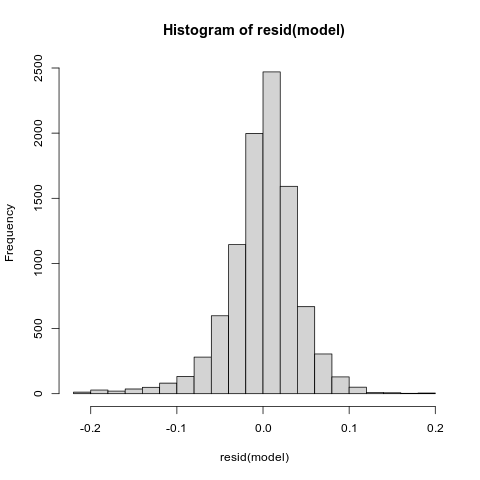

R[write to console]: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'object' in selecting a method for function 'show': bad 'data': object 'dat' not found

/home/ll16598/miniconda3/envs/SICC_AUG_22/lib/python3.8/site-packages/rpy2/robjects/robject.py:123: UserWarning: Invalid call to "show()" in R: Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'object' in selecting a method for function 'show': bad 'data': object 'dat' not found

  warnings.warn(f'Invalid call to "show()" in R: {rre}')
R[write to console]: Error: bad 'data': object 'dat' not found



RRuntimeError: Error: bad 'data': object 'dat' not found


In [197]:
#Run stats
%R stats_R_affect()

Plotting to characterise our networks.

1.9869105824778645e-24
2.5910579977620213e-26


/tmp/ipykernel_13412/2006656198.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_13412/2006656198.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_13412/2006656198.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_13412/2006656198.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_13412/2006656198.py:14

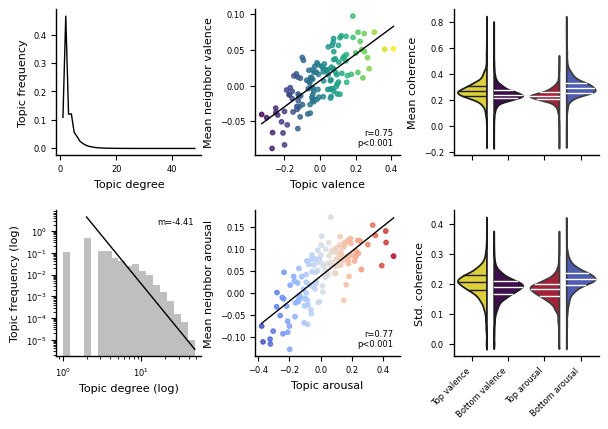

In [198]:
pointsize=10
alph=0.8
titlesize=8
labsize=6
labels_quant=['Top valence', 'Bottom valence', 'Top arousal', 'Bottom arousal']
savefig=False
degree_counts = {}
for G in df['graphs']:
    degrees = [degree for node, degree in nx.degree(G.to_undirected())]
    for degree in degrees:
        degree_counts[degree] = degree_counts.get(degree, 0) + 1

# Calculate sorted degrees and their frequencies
sorted_degrees = np.array(sorted(degree_counts.keys()))
frequencies = np.array([degree_counts[degree] for degree in sorted_degrees], dtype=float)
frequencies /= np.sum(frequencies)  # Normalize the frequencies

# Setup figure and axes
fig, axs = plt.subplots(2,3, figsize=(7, 4.5))
axs=axs.flatten()
# Plot unlogged frequency distribution
axs[0].plot(sorted_degrees, frequencies, marker='', linestyle='-', color='black', label='')
axs[0].set_xlabel("Topic degree", fontsize=titlesize)
axs[0].set_ylabel("Topic frequency", fontsize=titlesize)

# Prepare data for the histogram on a log scale
sorted_degrees += (sorted_degrees == 0)
frequencies += (frequencies == 0)

# Plot histogram on the second axis with log scale
num_bins=20
bin_edges = np.logspace(np.log10(sorted_degrees.min()), np.log10(sorted_degrees.max()), num_bins)
axs[3].hist(sorted_degrees, weights=frequencies, bins=bin_edges, color='grey', alpha=0.5, histtype='stepfilled')
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlabel("Topic degree (log)", fontsize=titlesize)
axs[3].set_ylabel("Topic frequency (log)", fontsize=titlesize)
# Take the logarithm of the data
sorted_degrees=sorted_degrees[1:len(sorted_degrees)]
frequencies=frequencies[1:len(frequencies)]

log_degrees = np.log(sorted_degrees)
log_frequencies = np.log(frequencies)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_frequencies)
# Create the line of best fit
x_fit = np.linspace(log_degrees.min(), log_degrees.max(), 100)
y_fit = slope * x_fit + intercept

# Plot the line of best fit
axs[3].plot(np.exp(x_fit), np.exp(y_fit), color='black', label=f'Linear fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}, p={p_value:.3f}')
axs[3].text(0.95, 0.95, f'm={slope:.2f}', transform=axs[3].transAxes, ha='right', va='top', color='black', fontsize=labsize)

cos_sim_values = [cossim_pos_neg[topic] for topic in grouped_data['Topic']]
norm = plt.Normalize(vmin=min(cos_sim_values), vmax=max(cos_sim_values))
colors = plt.cm.viridis(norm(cos_sim_values))
axs[1].scatter(grouped_data['Valence_OG'], grouped_data['Valence_Neighbours'], color=colors, alpha=alph, s=pointsize)
axs[1].set_xlabel('Topic valence', fontsize=titlesize)
axs[1].set_ylabel('Mean neighbor valence', fontsize=titlesize)
valence_og = np.array([v[0] for v in grouped_data['Valence_OG']])  # Remove NaN values
valence_neighbours = np.array(grouped_data['Valence_Neighbours'].dropna())  # Remove NaN values
correlation_coefficient = np.corrcoef(valence_og, valence_neighbours)[0][1]
slope, intercept, r_value, p_value, std_err = stats.linregress(valence_og,valence_neighbours)
x = np.linspace(min(grouped_data['Valence_OG']), max(grouped_data['Valence_OG']), 100)  # Generate 100 x values
y = slope * x + intercept  # Calculate y values based on the linear regression
axs[1].plot(x, y, color='black')  # Plot the regression line in red for visibility
print(p_value)
axs[1].text(0.95, 0.05, f'r={r_value:.2f}\np<0.001', transform=axs[1].transAxes, ha='right', va='bottom', color='black', fontsize=labsize)

cos_sim_values = [cossim_high_low[topic] for topic in grouped_data2['Topic']]
norm = plt.Normalize(vmin=min(cos_sim_values), vmax=max(cos_sim_values))
colors = plt.cm.coolwarm(norm(cos_sim_values))
axs[4].scatter(grouped_data2['Arousal_OG'], grouped_data2['Arousal_Neighbours'], color=colors, alpha=alph, s=pointsize)
axs[4].set_xlabel('Topic arousal', fontsize=titlesize)
axs[4].set_ylabel('Mean neighbor arousal', fontsize=titlesize)
arousal_og = np.array([v[0] for v in grouped_data2['Arousal_OG']])  # Remove NaN values
arousal_neighbours = np.array(grouped_data2['Arousal_Neighbours'].dropna())  # Remove NaN values
correlation_coefficient = np.corrcoef(arousal_og, arousal_neighbours)[0][1]
slope, intercept, r_value, p_value, std_err = stats.linregress(arousal_og,arousal_neighbours)
x = np.linspace(min(grouped_data2['Arousal_OG']), max(grouped_data2['Arousal_OG']), 100)  # Generate 100 x values
y = slope * x + intercept  # Calculate y values based on the linear regression
axs[4].plot(x, y, color='black')  # Plot the regression line in red for visibility
print(p_value)
axs[4].text(0.95, 0.05, f'r={r_value:.2f}\np<0.001', transform=axs[4].transAxes, ha='right', va='bottom', color='black', fontsize=labsize)
if text:
    # Annotate each point with its topic
    for i, topic in enumerate(grouped_data['Topic']):
        plt.annotate(topic, (grouped_data['Valence_OG'][i], grouped_data['Valence_Neighbours'][i]))

viridis_palette = sns.color_palette("viridis", as_cmap=True)
coolwarm_palette = sns.color_palette("coolwarm", as_cmap=True)
sentiment_colors = [viridis_palette(0.99), viridis_palette(0.01)]
arousal_colors = [coolwarm_palette(0.99), coolwarm_palette(0.01)]
sns.violinplot(
    data=plot_data_sentiment,
    x='Quantile',
    y='mean',
    ax=axs[2],
    palette=sentiment_colors,
    inner='quart',
    split=True,
    alpha=1
)
sns.violinplot(
    data=plot_data_arousal,
    x='Quantile',
    y='mean',
    ax=axs[2],
    palette=arousal_colors,
    inner='quart',
    split=True,
)
sns.violinplot(
    data=plot_data_sentiment,
    x='Quantile',
    y='std',
    ax=axs[5],
    palette=sentiment_colors,
    inner='quart',
    split=True,
)
sns.violinplot(
    data=plot_data_arousal,
    x='Quantile',
    y='std',
    ax=axs[5],
    palette=arousal_colors,
    inner='quart',
    split=True,
)

for e, l in enumerate(axs[2].lines):
    l.set_linestyle('-')  # Solid line
    l.set_linewidth(0.6)    # Set the line width
    if e in range(3,6) or e in range(6,12):
        l.set_color('white')
for e, l in enumerate(axs[5].lines):
    l.set_linestyle('-')  # Solid line
    l.set_linewidth(0.6)    # Set the line width
    if e in range(3,6) or e in range(6,12):
        l.set_color('white')
axs[2].set_xlabel('',fontsize=titlesize)
axs[5].set_xlabel('',fontsize=titlesize)
axs[2].set_ylabel('Mean coherence',fontsize=titlesize)
axs[5].set_ylabel('Std. coherence',fontsize=titlesize)
axs[2].set_xticklabels([])
axs[5].set_xticklabels(labels_quant, rotation=45, ha='right', fontsize =labsize)
for k,ax in enumerate(axs):
    ax.tick_params(axis='both', labelsize=labsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['left'].set_color(lincolor)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['bottom'].set_color(lincolor)
    for line in ax.lines:
        line.set_linewidth(linewidth2)
plt.subplots_adjust(wspace=0.37, hspace=0.38)
if savefig:
    plt.savefig(dir_fig_save+'net_characterisation.png', dpi=800,  bbox_inches='tight')


Next we will see how valence and arousal interact in our networks. We need to create dfs of mean degree against each of these affective dimensions

In [27]:
def calculate_metrics(df, sentiment_value, cossim_dict, affect, cmap_name='viridis'):
    total_degrees = defaultdict(int)
    count_per_node = defaultdict(int)
    narrative_count = defaultdict(int)

    df['Sentiment_Quantile'] = pd.qcut(df[affect], 4, labels=[0, 1, 2, 3])
    df_filtered=df[df['Sentiment_Quantile'].isin([sentiment_value])]
    for idx, row in df_filtered.iterrows():
        G = row['graphs']
        for node, degree in G.degree():
            total_degrees[node] += degree
            count_per_node[node] += 1
            narrative_count[node] += 1

    mean_degrees = {node: total_degrees[node] / count_per_node[node] for node in total_degrees}
    nodes = list(mean_degrees.keys())
    avg_degrees = [mean_degrees[node] for node in nodes]
    prevalences = [narrative_count[node] / len(df_filtered['graphs']) for node in nodes]
    
    df_result = pd.DataFrame({'degree': avg_degrees, 'prevalence': prevalences, 'node_id': nodes})
    
    cos_sim_values = [cossim_dict[str(node)] for node in nodes]
    norm = mcolors.Normalize(vmin=min(cos_sim_values), vmax=max(cos_sim_values))
    cmap = plt.cm.get_cmap(cmap_name)
    colors = [cmap(norm(value)) for value in cos_sim_values]
    
    return df_result, colors, norm

df_pos, colors_pos, norm_pos = calculate_metrics(corpus_cleaned, 3, cossim_pos_neg,'median_Valence', 'viridis')
df_neg, colors_neg, norm_neg = calculate_metrics(corpus_cleaned, 0, cossim_pos_neg,'median_Valence', 'viridis')
df_hi, colors_hi, norm_hi = calculate_metrics(corpus_cleaned, 3, cossim_high_low,'median_Arousal', 'coolwarm')
df_lo, colors_lo, norm_lo = calculate_metrics(corpus_cleaned, 0, cossim_high_low,'median_Arousal', 'coolwarm')


/tmp/ipykernel_5737/1989049763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_Quantile'] = pd.qcut(df[affect], 4, labels=[0, 1, 2, 3])
/tmp/ipykernel_5737/1989049763.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/tmp/ipykernel_5737/1989049763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [32]:
save_data_dir='/home/ll16598/Documents/altered_states/2024/degree_analysis/'
df_pos['quantile']='pos'
df_neg['quantile']='neg'
df_hi['quantile']='hi'
df_lo['quantile']='lo'
all_df_val=pd.concat([df_pos, df_neg])
all_df_aro=pd.concat([df_hi, df_lo])
all_df_val.to_csv(f'{save_data_dir}valence_quant.csv')
all_df_aro.to_csv(f'{save_data_dir}arousal_quant.csv')

Here is our R script to determine the interaction and generate model fits. Replace directories as appropriate.

In [33]:
%%R 
rm(list=ls())
library(lme4)
library(car)

stats_R_val <- function() { 
    dat_deg_val <- read.csv('/home/ll16598/Documents/altered_states/2024/degree_analysis/valence_quant.csv', header=T, stringsAsFactors = F)
    dat_deg_val$log_degree=log(dat_deg_val$degree)

    model <- lmer(log_degree~prevalence*quantile+(1|node_id),
                  data = dat_deg_val)

    #hist(resid(model))
    print(car::Anova(model, type='III'))
    print(summary(model))
    dat<-dat_deg_val
    prevalence_range <- max(dat$prevalence) - min(dat$prevalence)

    newdat <- expand.grid(
      prevalence = seq(min(dat$prevalence) - 0.05 * prevalence_range, max(dat$prevalence) + 0.05 * prevalence_range, length.out = 100),
      quantile = unique(dat$quantile)
    )

    # Predict using the new data frame
    newdat$log_degree <- predict(model, newdat, re.form=NA)
    newdat$degree<-exp(newdat$log_degree)
  return(newdat)
}

stats_R_aro <- function() { 
    dat_aro_val <- read.csv('/home/ll16598/Documents/altered_states/2024/degree_analysis/arousal_quant.csv', header=T, stringsAsFactors = F)
    dat_aro_val$log_degree=log(dat_aro_val$degree)
    model_aro <- lmer(log_degree~prevalence*quantile+(1|node_id),
                  data = dat_aro_val)
    print(car::Anova(model_aro, type='III'))
    print(summary(model_aro))
    
    dat<-dat_aro_val
    prevalence_range <- max(dat$prevalence) - min(dat$prevalence)

    newdat <- expand.grid(
      prevalence = seq(min(dat$prevalence) - 0.05 * prevalence_range, max(dat$prevalence) + 0.05 * prevalence_range, length.out = 100),
      quantile = unique(dat$quantile)
    )

    # Predict using the new data frame
    newdat$log_degree <- predict(model_aro, newdat, re.form=NA)
    newdat$degree<-exp(newdat$log_degree)
  return(newdat)
}

Loading required package: Matrix
Loading required package: carData


In [34]:
#Run stats
%R -o fit_valence fit_valence <- stats_R_val()
%R -o fit_arousal fit_arousal <- stats_R_aro()
fit_valence_top=fit_valence[fit_valence['quantile']=='pos']
fit_valence_bottom=fit_valence[fit_valence['quantile']=='neg']
fit_arousal_top=fit_arousal[fit_arousal['quantile']=='hi']
fit_arousal_bottom=fit_arousal[fit_arousal['quantile']=='lo']

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: log_degree
                        Chisq Df Pr(>Chisq)    
(Intercept)         6196.0727  1  < 2.2e-16 ***
prevalence          1564.4491  1  < 2.2e-16 ***
quantile               4.0838  1     0.0433 *  
prevalence:quantile   22.5908  1  2.004e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['lmerMod']
Formula: log_degree ~ prevalence * quantile + (1 | node_id)
   Data: dat_deg_val

REML criterion at convergence: -611.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.67835 -0.56665 -0.05492  0.45332  2.38584 

Random effects:
 Groups   Name        Variance Std.Dev.
 node_id  (Intercept) 0.004104 0.06406 
 Residual             0.002462 0.04962 
Number of obs: 260, groups:  node_id, 130

Fixed effects:
                       Estimate Std. Error t value
(Intercept)             0.84970    0.01079  78.715
prevalence              1.56864    0.039

Plotting:

/tmp/ipykernel_5737/3453734614.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_Quantile'] = pd.qcut(df[param], 4, labels=[0, 1, 2, 3])
/tmp/ipykernel_5737/3453734614.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/tmp/ipykernel_5737/3453734614.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  scatter = ax.scatter(prevalences, avg_degrees, s=pointsize2, alpha=0.7, c=colors, norm=norm)
/tmp/ipykernel_5737/3453734614.py:35: SettingWithCopyWarning: 
A value is trying to be s

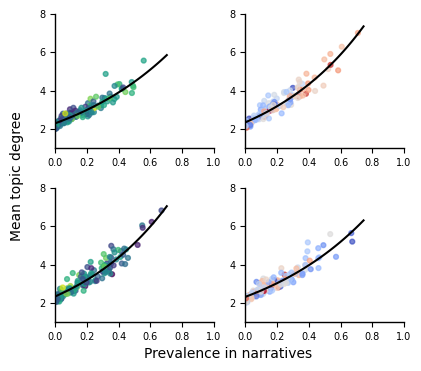

In [42]:
df=corpus_cleaned
param1='median_Valence'
param2='median_Arousal'
text=False # label nodes
savefig=False #sace figure
def calculate_mean_degrees(corp_filt):
    total_degrees = defaultdict(int)
    count_per_node = defaultdict(int)
    narrative_count = defaultdict(int)
    
    for idx, row in corp_filt.iterrows():
        G = row['graphs']
        for node, degree in G.degree():
            total_degrees[node] += degree
            count_per_node[node] += 1
            narrative_count[node] += 1

    mean_degrees = {node: total_degrees[node]/count_per_node[node] for node in total_degrees}
    prevalences = [narrative_count[node]/len(corp_filt['graphs']) for node in total_degrees]
    
    return list(mean_degrees.keys()), list(mean_degrees.values()), prevalences

def plot_graph(ax, nodes, avg_degrees, prevalences, cos_sim_values, cmap_name):
    norm = mcolors.Normalize(vmin=min(cos_sim_values), vmax=max(cos_sim_values))
    cmap = plt.cm.get_cmap(cmap_name)
    colors = [cmap(norm(value)) for value in cos_sim_values]
    scatter = ax.scatter(prevalences, avg_degrees, s=pointsize2, alpha=0.7, c=colors, norm=norm)
    if text:
        for i, txt in enumerate(nodes):
            ax.text(prevalences[i], avg_degrees[i], txt, fontsize=fs)
    
    return scatter

def process_and_plot(df, param, quantile, ax,cossim_dict, cmap_name):
    df['Sentiment_Quantile'] = pd.qcut(df[param], 4, labels=[0, 1, 2, 3])
    corp_filt = df[df['Sentiment_Quantile'].isin(quantile)]
    nodes, avg_degrees, prevalences = calculate_mean_degrees(corp_filt)
    cos_sim_values = [cossim_dict[str(node)] for node in nodes]  # or cossim_high_low
    return plot_graph(ax, nodes, avg_degrees, prevalences, cos_sim_values, cmap_name)

fig, axs = plt.subplots(2, 2, figsize=(4.5, 4))  # 1 row, 2 columns
axs = axs.flatten()
process_and_plot(df, param1, [3], axs[0],cossim_pos_neg, 'viridis')
process_and_plot(df, param1, [0], axs[2],cossim_pos_neg, 'viridis')
process_and_plot(df, param2, [3], axs[1],cossim_high_low, 'coolwarm')
process_and_plot(df, param2, [0], axs[3],cossim_high_low, 'coolwarm')

fit_valence_top = fit_valence[fit_valence['quantile'] == 'pos']
fit_valence_bottom = fit_valence[fit_valence['quantile'] == 'neg']
fit_arousal_top = fit_arousal[fit_arousal['quantile'] == 'hi']
fit_arousal_bottom = fit_arousal[fit_arousal['quantile'] == 'lo']

axs[0].plot(fit_valence_top['prevalence'], fit_valence_top['degree'], color='black')
axs[1].plot(fit_arousal_top['prevalence'], fit_arousal_top['degree'], color='black')
axs[2].plot(fit_valence_bottom['prevalence'], fit_valence_bottom['degree'], color='black')
axs[3].plot(fit_arousal_bottom['prevalence'], fit_arousal_bottom['degree'], color='black')

for ax in axs:
    ax.tick_params(axis='both', labelsize=labsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(linewidth2)
    ax.spines['left'].set_color(lincolor)
    ax.spines['bottom'].set_linewidth(linewidth2)
    ax.spines['bottom'].set_color(lincolor)
    ax.set_ylim(1, 8)
    ax.set_xlim(0, 1)

# max_y_value_ax0 = max(avg_degrees)
# axs[1].axhline(max_y_value_ax0, color='black', linestyle='--', linewidth=linewidth2)

fig.text(0.04, 0.32, 'Mean topic degree', ha='center', rotation=90, fontsize=titlesize)
fig.text(0.51, 0.02, 'Prevalence in narratives', ha='center', fontsize=titlesize)

plt.subplots_adjust(wspace=0.2, hspace=0.3)

if savefig:
    plt.savefig(dir_fig_save + 'degree_valence_arousal.png', dpi=800, bbox_inches='tight')

plt.show()
